<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Identifying-why-min->-max-change-album_purchase" data-toc-modified-id="Identifying-why-min->-max-change-album_purchase-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Identifying why min-&gt; max change album_purchase</a></span></li><li><span><a href="#Checking-the-invoice-vs-album-tracks" data-toc-modified-id="Checking-the-invoice-vs-album-tracks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Checking the invoice vs album tracks</a></span></li></ul></div>

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.max_rows = 999

In [2]:
db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");   
    '''
    return run_query(q)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


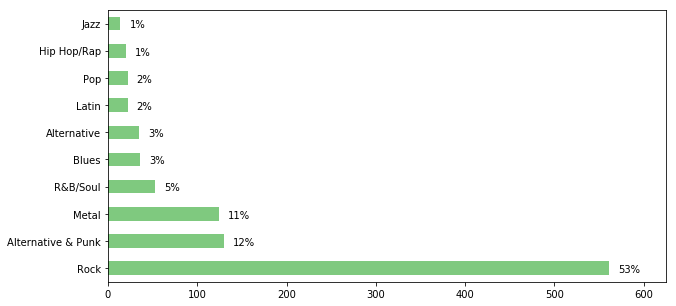

In [4]:
q = '''
    SELECT 
        g.name genre,
        COUNT(*) popularity,
        100.0*COUNT(*)/(SELECT COUNT(*) FROM invoice i 
                    INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id WHERE i.billing_country = 'USA') percent 
    FROM invoice i 
    INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id   
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    WHERE i.billing_country = "USA"
    GROUP BY genre
    ORDER BY popularity DESC
    LIMIT 10
'''
genre_sales_usa = run_query(q)
genre_sales_usa.set_index('genre',inplace=True)

ax = genre_sales_usa.popularity.plot.barh(figsize=(10,5),colormap=plt.cm.Accent,xlim=(0, 625))
#plt.rc('axes', labelsize= 15) 
#plt.rc('ytick', labelsize=15)
#plt.rc('legend', fontsize=12)
plt.ylabel('') 

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "popularity"]
    label = (genre_sales_usa.loc[label, "percent"]
            ).astype(int).astype(str) + "%"
    plt.annotate(label, (score + 10, i -0.15 ))



According to the bar graph, punk, blues, pop are the top 3 genres out of the 4 available. So the store should stock these 3 genres with their corresponding artists. These 3 genres combined only make 17% of the market, the store should stock rock genres too to fit the tastes of more customers.

In [7]:
q = '''
     CREATE VIEW IF NOT EXISTS rep_performance AS
        SELECT 
             c.support_rep_id,
             SUM(i.total) sales
        FROM customer c
        INNER JOIN invoice i ON c.customer_id = i.customer_id    
        GROUP BY 1
    '''
run_command(q)

In [8]:
q = '''
    SELECT
    e.first_name||' '||e.last_name employee,
    hire_date,
    sales
    FROM employee e
    INNER JOIN 
    rep_performance rp ON rp.support_rep_id = e.employee_id

'''

sales = run_query(q)
sales.set_index('employee',inplace=True)
sales.hire_date = pd.to_datetime(sales.hire_date)
sales.plot.barh(legend=False)
plt.ylabel('') 

    

ValueError: ordinal must be >= 1

ValueError: ordinal must be >= 1

Their sales performance are related to hire_date, Steve being hired the lastest has the least total. However, the gap of sales/difference in months-hired between Steve and Margeret is smaller than the gap between Margaret and Jane, so Steve is doing well. 

In [ ]:
q = "SELECT * FROM invoice i INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id"
run_query(q)

In [ ]:
sales_by_country ='''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer 
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       i.total  
    FROM customer c 
    INNER JOIN invoice i ON i.customer_id = c.customer_id)
    
    
    SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
    FROM
    (SELECT 
        country,
        COUNT(DISTINCT(customer_id)) customers,
        SUM(total) total_sales,
        SUM(total)/COUNT(DISTINCT(customer_id)) customer_lifetime_value,
        AVG(total) average_order,

        CASE 
            WHEN country == 'Other' THEN 1
            ELSE 0
        END as sort
    
    FROM country_or_other
    GROUP BY country
    ORDER BY sort,total_sales DESC)
'''
country_metrics = run_query(sales_by_country)
country_metrics.set_index('country',inplace=True)

In [ ]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Set1(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 18))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()
country_metrics


USA has the highest total sales, more than 2x rank2 Canada. The total sales amount is strongly correlated with number of customers since average_order per customer is similar among all countries. May be good to look at customer_lifetime_value, where Czech Republic is high. If the marketing team can attract more customers from Czech Republic, each customer will add the largest amount to total sales compared to customers from other countries.

UK and India also have next 2 highest average order values after Czech, they may also be good targets. The amount of customers these 3 countries (2,3,2) are very little. A smaller test campaign is prudent to ensure that such spending patterns apply to a larger population of these countries

In [ ]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MAX(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )
 
SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
 
                  EXCEPT
 
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
 
                  EXCEPT
 
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase
'''

run_query(albums_vs_tracks)

In [ ]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )
    ,
    
    album_invoice AS 
    (
     SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = t2.album_id
                                     
                  EXCEPT 
                  
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
     INNER JOIN track t2 ON t2.track_id = ifs.first_track_id
     WHERE album_purchase = 'yes'
     )
     
     SELECT ai.*,il.*,t.album_id
     from album_invoice ai
     INNER JOIN invoice_line il 
     ON il.invoice_id = ai.invoice_id
     INNER JOIN track t 
     ON t.track_id = il.track_id

  

    
'''

run_query(albums_vs_tracks)

# Identifying why min-> max change album_purchase

In [ ]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    ),
    
    min_album AS
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                                     
                  EXCEPT 
                  
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    ),
    
    invoice_first_track_max AS
    (
    SELECT
         il.invoice_id invoice_id,
         MAX(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    ),
    max_album AS
    (
     SELECT
        ifsm.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifsm.first_track_id
                                     ) 
                                     
                  EXCEPT 
                  
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifsm.invoice_id
                 ) IS NULL THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track_max ifsm
    )
        
     SELECT * FROM min_album
    INNER JOIN max_album 
    ON min_album.invoice_id = max_album.invoice_id
    AND min_album.album_purchase != max_album.album_purchase
    AND min_album.album_purchase = 'no'
'''

    
run_query(albums_vs_tracks)

# Checking the invoice vs album tracks

In [ ]:
q = '''
    SELECT il.invoice_id,il.track_id, t.album_id
    FROM invoice_line il 
    INNER JOIN track t 
    ON t.track_id = il.track_id AND invoice_id IN (20,27,38,39,59,67)
    ORDER BY invoice_id,t.track_id
'''



q2 = '''
    SELECT track_id FROM track WHERE album_id = 278
    '''
display(run_query(q2))

run_query(q)


In [ ]:
albums_vs_tracks_2 = '''
WITH invoice_first_track AS 
    (
     SELECT
         il.invoice_id invoice_id,
         i.customer_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     GROUP BY 1, 2
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                       ) percent
FROM
    (
    SELECT
        ifs.*,
        t.album_id,
        CASE
            WHEN
                (
                 SELECT t3.track_id FROM track t3
                 WHERE t3.album_id = t.album_id
                 
                 EXCEPT
                 
                 SELECT il2.track_id FROM invoice_line il2
                 INNER JOIN invoice i2 ON i2.invoice_id = il2.invoice_id
                
                 
                 WHERE
                         il2.invoice_id <= ifs.invoice_id
                     AND i2.customer_id = ifs.customer_id
                    
                ) IS NULL THEN "yes"
            ELSE "no"
        END AS "album_purchase"
    FROM invoice_first_track ifs
    INNER JOIN track t ON ifs.first_track_id = t.track_id
    )
GROUP BY 1
'''

run_query(albums_vs_tracks_2)

About 1/5 of invoices come from albums, such sales may be lost if the owner gives up purchasing albums. However the increase in profits from selling individual tracks may outweight lost sales from albums. This depends on the price of an album vs individual tracks, which is not provided in the question. Stocking by tracks also allows customers the flexibility of buying an album track by track (the results show 22 (139-117) albums bought through more than 1 invoice). Stocking albums vs tracks also depends on costs of stocking individual vs album


In [ ]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         Min(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                                     
                  EXCEPT 
                  
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase
'''

run_query(albums_vs_tracks)